# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

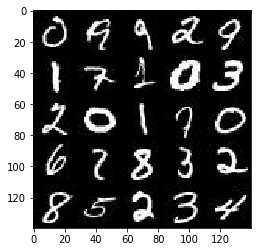

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

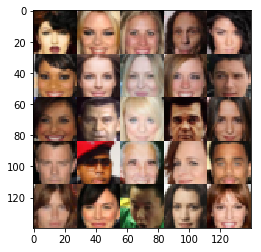

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 
                                 name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learn_rate = tf.placeholder(tf.float32, None, name='learn_rate')
    
    return inputs_real, inputs_z, learn_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
        
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer - 28x28x3 ; no batch_normalization for first layer
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha*x1, x1)  # leaky Relu
        # layer - 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*x2, x2)  # leaky Relu
        # layer - 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*x3, x3)  # leaky Relu
        # layer - 4x4x256
        
        flatten = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # fully-connected 
        x1 = tf.layers.dense(z, 7*7*256)
        
        # reshape for convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1) # leaky Relu
        # layer - 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2) # leaky Relu
        # layer - 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3) # leaky Relu
        # layer - 28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(images=input_real)
    d_model_fake, d_logits_fake = discriminator(images=g_model, reuse=True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
        
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_vars = tf.trainable_variables()
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                             beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                             beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # image dimensions
    _, image_width, image_height, image_channels = data_shape
    
    # model inputs
    inputs_real, inputs_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # model losses
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    
    # model optimizers
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    
    print_every = 50
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                                
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, 
                                                     inputs_z: batch_z,
                                                     learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, 
                                                     inputs_z: batch_z,
                                                     learn_rate: learning_rate})
                
                steps += 1
                
                if steps % print_every == 0:
                    # obtain losses and print out after every 50 epochs
                    train_loss_d = d_loss.eval({inputs_z: batch_z, 
                                                inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Steps {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 20, inputs_z, image_channels, data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Steps 50... Discriminator Loss: 2.7248... Generator Loss: 2.0287
Epoch 1/2... Steps 100... Discriminator Loss: 1.8137... Generator Loss: 1.1568


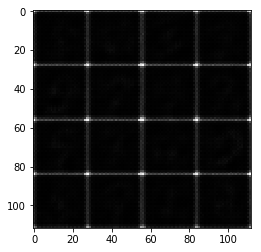

Epoch 1/2... Steps 150... Discriminator Loss: 1.6587... Generator Loss: 1.5049
Epoch 1/2... Steps 200... Discriminator Loss: 1.4096... Generator Loss: 1.4319


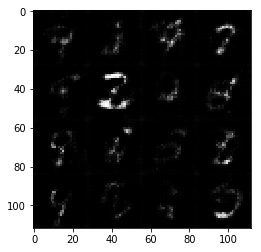

Epoch 1/2... Steps 250... Discriminator Loss: 1.0197... Generator Loss: 1.9384
Epoch 1/2... Steps 300... Discriminator Loss: 1.3147... Generator Loss: 1.5322


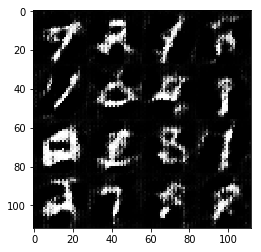

Epoch 1/2... Steps 350... Discriminator Loss: 1.3978... Generator Loss: 1.5398
Epoch 1/2... Steps 400... Discriminator Loss: 1.2923... Generator Loss: 1.3324


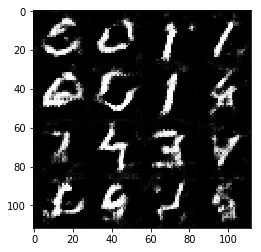

Epoch 1/2... Steps 450... Discriminator Loss: 1.4447... Generator Loss: 1.3311
Epoch 1/2... Steps 500... Discriminator Loss: 1.4420... Generator Loss: 1.2760


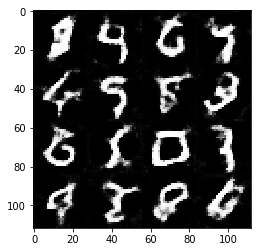

Epoch 1/2... Steps 550... Discriminator Loss: 1.3247... Generator Loss: 0.5988
Epoch 1/2... Steps 600... Discriminator Loss: 1.5256... Generator Loss: 1.9228


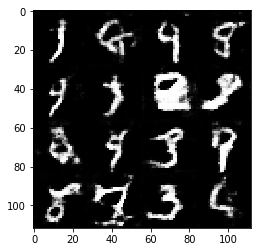

Epoch 1/2... Steps 650... Discriminator Loss: 1.3434... Generator Loss: 0.6028
Epoch 1/2... Steps 700... Discriminator Loss: 1.4376... Generator Loss: 0.4683


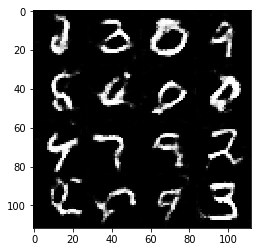

Epoch 1/2... Steps 750... Discriminator Loss: 1.5396... Generator Loss: 0.4101
Epoch 1/2... Steps 800... Discriminator Loss: 2.2036... Generator Loss: 0.1942


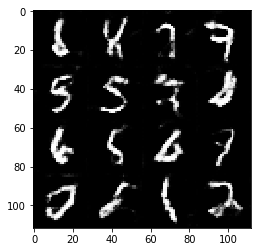

Epoch 1/2... Steps 850... Discriminator Loss: 1.6856... Generator Loss: 1.4325
Epoch 1/2... Steps 900... Discriminator Loss: 1.4718... Generator Loss: 0.4778


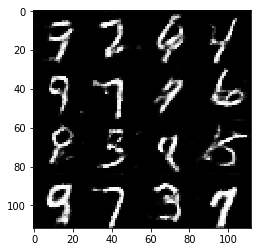

Epoch 2/2... Steps 950... Discriminator Loss: 1.2781... Generator Loss: 0.7391
Epoch 2/2... Steps 1000... Discriminator Loss: 1.7787... Generator Loss: 0.3022


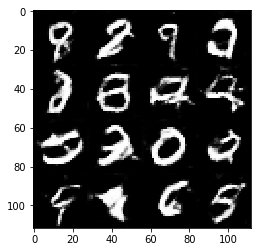

Epoch 2/2... Steps 1050... Discriminator Loss: 1.4324... Generator Loss: 0.4623
Epoch 2/2... Steps 1100... Discriminator Loss: 1.6561... Generator Loss: 1.7317


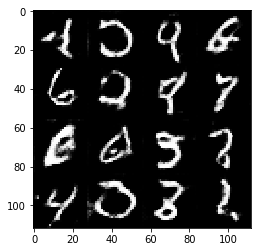

Epoch 2/2... Steps 1150... Discriminator Loss: 2.7888... Generator Loss: 0.1342
Epoch 2/2... Steps 1200... Discriminator Loss: 1.3066... Generator Loss: 0.5352


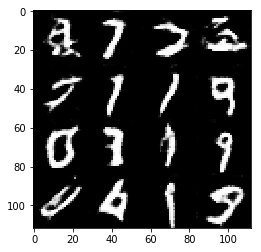

Epoch 2/2... Steps 1250... Discriminator Loss: 1.1748... Generator Loss: 0.7564
Epoch 2/2... Steps 1300... Discriminator Loss: 1.7210... Generator Loss: 2.2377


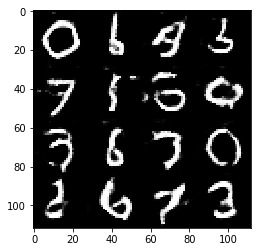

Epoch 2/2... Steps 1350... Discriminator Loss: 1.2235... Generator Loss: 1.3737
Epoch 2/2... Steps 1400... Discriminator Loss: 1.2331... Generator Loss: 0.5997


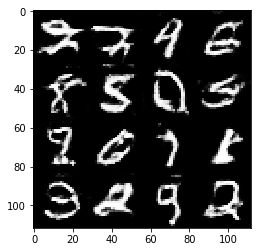

Epoch 2/2... Steps 1450... Discriminator Loss: 2.1560... Generator Loss: 0.2262
Epoch 2/2... Steps 1500... Discriminator Loss: 1.6210... Generator Loss: 0.3607


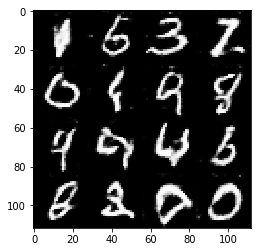

Epoch 2/2... Steps 1550... Discriminator Loss: 0.9944... Generator Loss: 1.5958
Epoch 2/2... Steps 1600... Discriminator Loss: 1.0234... Generator Loss: 1.1068


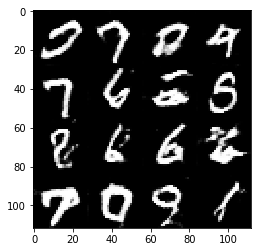

Epoch 2/2... Steps 1650... Discriminator Loss: 1.2116... Generator Loss: 0.5810
Epoch 2/2... Steps 1700... Discriminator Loss: 2.2858... Generator Loss: 0.1895


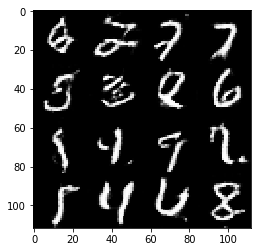

Epoch 2/2... Steps 1750... Discriminator Loss: 1.9179... Generator Loss: 0.2764
Epoch 2/2... Steps 1800... Discriminator Loss: 0.9813... Generator Loss: 1.2728


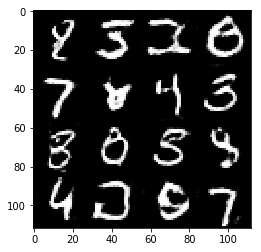

Epoch 2/2... Steps 1850... Discriminator Loss: 0.9781... Generator Loss: 0.9451


In [17]:
batch_size = 64 
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Steps 50... Discriminator Loss: 1.0045... Generator Loss: 5.7921
Epoch 1/1... Steps 100... Discriminator Loss: 0.5606... Generator Loss: 2.5801


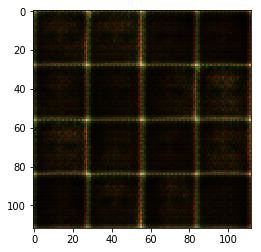

Epoch 1/1... Steps 150... Discriminator Loss: 0.3717... Generator Loss: 5.2041
Epoch 1/1... Steps 200... Discriminator Loss: 1.8732... Generator Loss: 0.3121


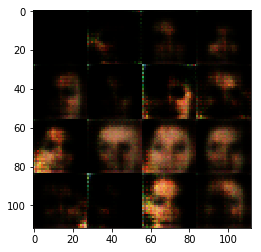

Epoch 1/1... Steps 250... Discriminator Loss: 1.1834... Generator Loss: 1.3078
Epoch 1/1... Steps 300... Discriminator Loss: 1.0390... Generator Loss: 0.7822


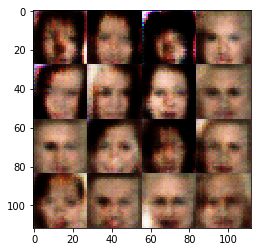

Epoch 1/1... Steps 350... Discriminator Loss: 0.8573... Generator Loss: 2.3387
Epoch 1/1... Steps 400... Discriminator Loss: 1.1013... Generator Loss: 1.0872


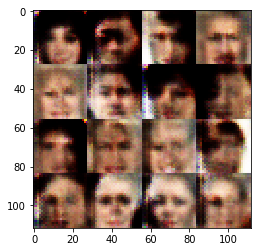

Epoch 1/1... Steps 450... Discriminator Loss: 1.2260... Generator Loss: 0.7557
Epoch 1/1... Steps 500... Discriminator Loss: 1.1678... Generator Loss: 1.0262


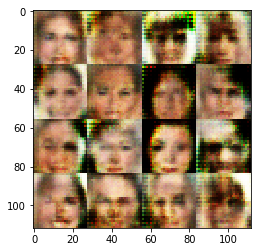

Epoch 1/1... Steps 550... Discriminator Loss: 0.8425... Generator Loss: 1.7736
Epoch 1/1... Steps 600... Discriminator Loss: 1.2789... Generator Loss: 1.2856


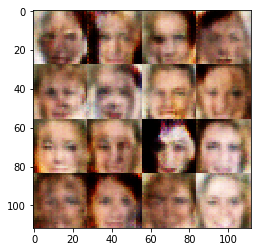

Epoch 1/1... Steps 650... Discriminator Loss: 1.0975... Generator Loss: 0.9084
Epoch 1/1... Steps 700... Discriminator Loss: 1.4308... Generator Loss: 0.5623


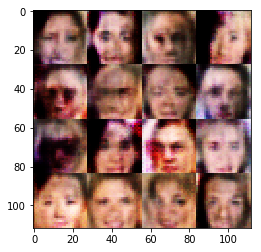

Epoch 1/1... Steps 750... Discriminator Loss: 0.9580... Generator Loss: 0.8942
Epoch 1/1... Steps 800... Discriminator Loss: 1.4100... Generator Loss: 0.6720


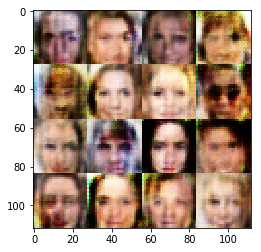

Epoch 1/1... Steps 850... Discriminator Loss: 2.5565... Generator Loss: 2.5471
Epoch 1/1... Steps 900... Discriminator Loss: 0.7950... Generator Loss: 1.1362


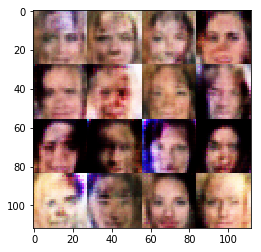

Epoch 1/1... Steps 950... Discriminator Loss: 1.3682... Generator Loss: 1.0152
Epoch 1/1... Steps 1000... Discriminator Loss: 1.1116... Generator Loss: 1.1692


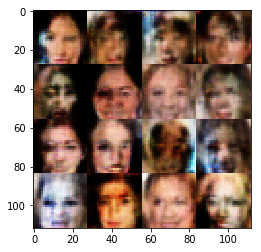

Epoch 1/1... Steps 1050... Discriminator Loss: 1.4008... Generator Loss: 0.6360
Epoch 1/1... Steps 1100... Discriminator Loss: 1.2004... Generator Loss: 0.9822


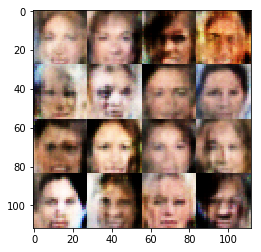

Epoch 1/1... Steps 1150... Discriminator Loss: 1.7472... Generator Loss: 0.3484
Epoch 1/1... Steps 1200... Discriminator Loss: 1.0268... Generator Loss: 1.0823


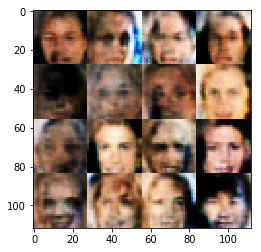

Epoch 1/1... Steps 1250... Discriminator Loss: 1.1038... Generator Loss: 0.7437
Epoch 1/1... Steps 1300... Discriminator Loss: 1.3413... Generator Loss: 0.8283


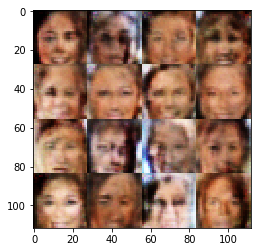

Epoch 1/1... Steps 1350... Discriminator Loss: 1.4458... Generator Loss: 0.7236
Epoch 1/1... Steps 1400... Discriminator Loss: 1.4487... Generator Loss: 0.7560


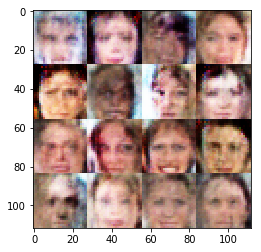

Epoch 1/1... Steps 1450... Discriminator Loss: 1.3968... Generator Loss: 0.8863
Epoch 1/1... Steps 1500... Discriminator Loss: 1.4944... Generator Loss: 0.7280


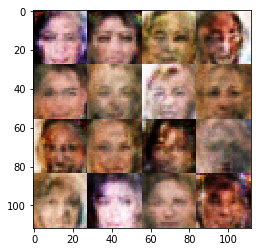

Epoch 1/1... Steps 1550... Discriminator Loss: 1.4312... Generator Loss: 0.8236
Epoch 1/1... Steps 1600... Discriminator Loss: 1.3541... Generator Loss: 0.7818


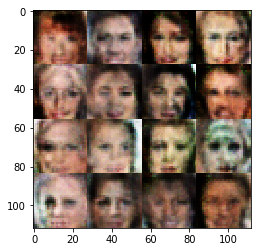

Epoch 1/1... Steps 1650... Discriminator Loss: 1.3276... Generator Loss: 0.7014
Epoch 1/1... Steps 1700... Discriminator Loss: 1.1887... Generator Loss: 0.8256


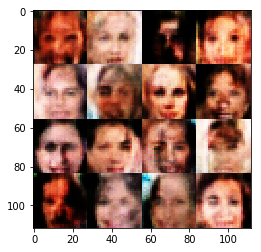

Epoch 1/1... Steps 1750... Discriminator Loss: 1.3258... Generator Loss: 1.1589
Epoch 1/1... Steps 1800... Discriminator Loss: 1.4137... Generator Loss: 0.6757


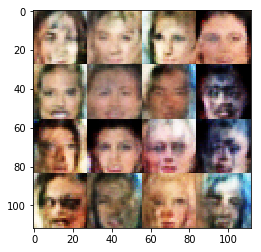

Epoch 1/1... Steps 1850... Discriminator Loss: 1.1814... Generator Loss: 1.4533
Epoch 1/1... Steps 1900... Discriminator Loss: 0.8064... Generator Loss: 2.3174


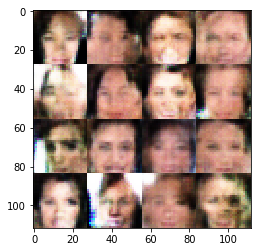

Epoch 1/1... Steps 1950... Discriminator Loss: 1.8830... Generator Loss: 1.3630
Epoch 1/1... Steps 2000... Discriminator Loss: 1.2529... Generator Loss: 0.7984


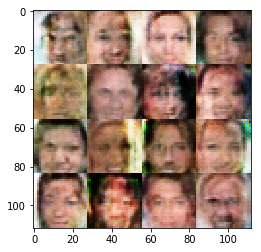

Epoch 1/1... Steps 2050... Discriminator Loss: 1.4139... Generator Loss: 0.8550
Epoch 1/1... Steps 2100... Discriminator Loss: 1.3729... Generator Loss: 0.7443


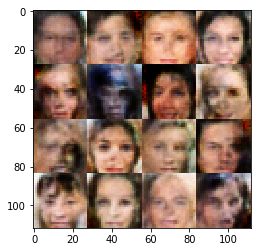

Epoch 1/1... Steps 2150... Discriminator Loss: 1.4246... Generator Loss: 0.6716
Epoch 1/1... Steps 2200... Discriminator Loss: 1.4757... Generator Loss: 0.7784


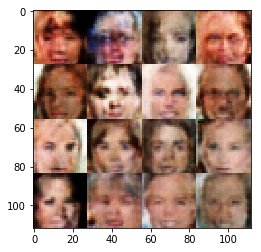

Epoch 1/1... Steps 2250... Discriminator Loss: 1.7304... Generator Loss: 0.6429
Epoch 1/1... Steps 2300... Discriminator Loss: 1.3212... Generator Loss: 0.8499


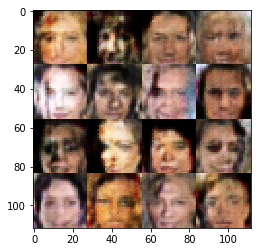

Epoch 1/1... Steps 2350... Discriminator Loss: 1.4463... Generator Loss: 0.8749
Epoch 1/1... Steps 2400... Discriminator Loss: 1.2832... Generator Loss: 0.8828


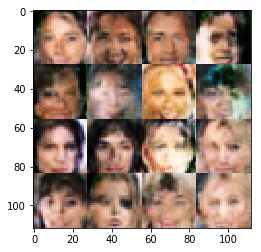

Epoch 1/1... Steps 2450... Discriminator Loss: 1.3827... Generator Loss: 0.7580
Epoch 1/1... Steps 2500... Discriminator Loss: 1.4924... Generator Loss: 0.7764


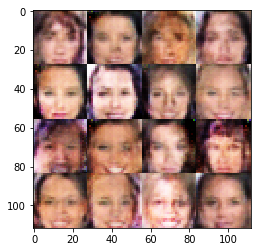

Epoch 1/1... Steps 2550... Discriminator Loss: 1.4444... Generator Loss: 0.8141
Epoch 1/1... Steps 2600... Discriminator Loss: 1.3812... Generator Loss: 0.7750


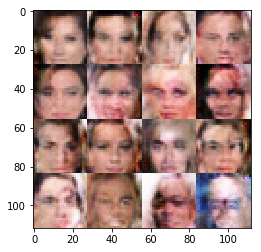

Epoch 1/1... Steps 2650... Discriminator Loss: 1.5181... Generator Loss: 0.7072
Epoch 1/1... Steps 2700... Discriminator Loss: 1.4999... Generator Loss: 0.7282


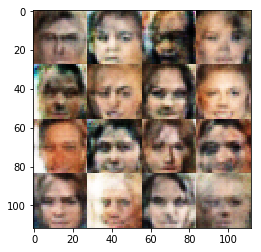

Epoch 1/1... Steps 2750... Discriminator Loss: 1.3272... Generator Loss: 1.0102
Epoch 1/1... Steps 2800... Discriminator Loss: 1.6007... Generator Loss: 0.3749


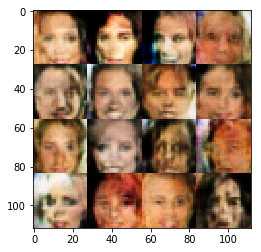

Epoch 1/1... Steps 2850... Discriminator Loss: 1.4404... Generator Loss: 1.3811
Epoch 1/1... Steps 2900... Discriminator Loss: 1.1464... Generator Loss: 0.9084


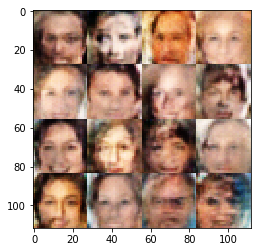

Epoch 1/1... Steps 2950... Discriminator Loss: 1.5738... Generator Loss: 0.4521
Epoch 1/1... Steps 3000... Discriminator Loss: 1.3170... Generator Loss: 1.1828


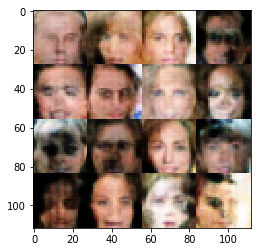

Epoch 1/1... Steps 3050... Discriminator Loss: 1.3448... Generator Loss: 0.8115
Epoch 1/1... Steps 3100... Discriminator Loss: 1.3754... Generator Loss: 0.7327


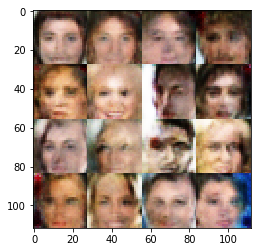

In [ ]:
batch_size = 64 
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.